In [ ]:
! pip install beir
! pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! git clone https://github.com/beir-cellar/beir.git
%cd beir
! sudo pip install -e .

fatal: destination path 'beir' already exists and is not an empty directory.
/content/beir
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/beir
  Attempting uninstall: beir
    Found existing installation: beir 1.0.1
    Can't uninstall 'beir'. No files were found to uninstall.
  Running setup.py develop for beir


In [ ]:
! pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create a searchable index

## Question 1: Explain the data structure. What are the three values returned by Beir, and how are they presented.

In [ ]:
from beir import util, LoggingHandler
#from beir.retrieval import models
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES

import logging
import pathlib, os

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

#### Download scifact.zip dataset and unzip the dataset
dataset = "dbpedia-entity"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
out_dir = "beir/datasets"
data_path = util.download_and_unzip(url, out_dir)

#### Provide the data_path where scifact has been downloaded and unzipped
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

/content/beir/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/4635922 [00:00<?, ?it/s]

The DBPedia entity dataset contains a corpus, queries and qrels (relevance judgments file) in which there are 2 files ("dev.tsv" and "test.tsv").

The corpus is a .jsonl file that contains a list of dictionaries, each with 4 fields:
- *_id* a string that represents the unique document id
- *title* a string denoting the title of the document
- *text* a string denoting a paragraph or passage of the document
- *metadata* a string of a url link of the document on dbpedia.org.

  For example: {"_id": "<dbpedia:Animalia_(book)>", "title": "Animalia (book)", "text": "Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over three million copies have been sold.   A special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.", "metadata": {"url": "<http://dbpedia.org/resource/Animalia_(book)>"}}

queries is a .jsonl file that contains a list of dictionaries, each with 3 fields:
- *_id* a unique query identifier
- *text* a query text. 
- *metadata* (it is empty)
  
  For example: {"_id": "INEX_LD-20120112", "text": "vietnam war facts", "metadata": {}}

The qrels folder's .tsv files  that contain three columns:
- *query-id* unique query id (from *queries* file)
- *corpus-id* unique document id (from *corpus* file)
- *score* an integer denoting the relevance judgement between query and document, meaning how well a retrieved document or set of documents meets the information need of the user.

  For example: INEX_LD-2009022	<dbpedia:Chili_oil>	2




## Question 2: To ease the problem, extract all the document from the corpus which are relevant to at least one query. Then, add 100K random documents which are not relevant to any query. Make sure the process is reproducible by setting the random seed on whatever random sampling method you use.

In [ ]:
texts = []
corpus_query_ids = []
ids = []
query_ids = []
query_texts = []

for query_id, values in qrels.items():
    query_ids.append(query_id)
    query_texts.append(queries[query_id])
    for dbpedia, value in values.items():
        if value > 0:
            corpus_query_ids.append(query_id)
            texts.append(corpus[dbpedia]['text'])
            ids.append(dbpedia)

In [ ]:
import random as rd

SEED = 30
rd.seed(SEED)

In [ ]:
random_list = rd.sample(range(0,4635922), 200000)

In [ ]:
corpus_ids = list(corpus.keys())

irrelevant_corpus = []
irrelevant_ids = []
for id in random_list:
    if len(irrelevant_corpus) == 100000:
        break
    id = corpus_ids[id]
    if id not in ids:
        irrelevant_corpus.append(corpus[id]['text'])
        irrelevant_ids.append(id)

ids.extend(irrelevant_ids)
texts.extend(irrelevant_corpus)

In [ ]:
corpus_query_ids.extend([None for _ in range(100000)])

## Question 3: Embed the reduced corpus and the queries using the chosen model

Note that sentence-transformers allows you to normalize the projection. So you can later use a simple inner product instead of a cosine similarity (remember the cosine similarity is equivalent to the inner product of the normalized vectors).

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

#model = SentenceTransformer('msmarco-MiniLM-L-6-v3')

model = SentenceTransformer('msmarco-distilbert-base-v4')
queries_embeddings = model.encode(query_texts)
embeddings = model.encode(texts)

##  Question 4: Using the annotated set of queries, compute the Mean Average Precision (MAP) @100 as well as the average time per query.

In [ ]:
hits = util.semantic_search(queries_embeddings, embeddings, top_k = 100, score_function=util.dot_score)

In [ ]:
def add_query_judgements(hits: list) -> list:
    """
    Parameters:
      hits: It's a list of lists where each sublist contains
       dictionaries of the corpus_id and the relevant score. 
    Returns
      A metric: It's a list of lists where each sublist contains 
      all judgements (relevant or not based on the label of the given data.)
    """
    metrics = []
    for index, hit in enumerate(hits):
        query = query_ids[index]
        query_judgements = []
        for dic in hit:
            if query == corpus_query_ids[dic['corpus_id']]:
                query_judgements.append('R')
            else:
                query_judgements.append('N') 

            metrics.append(query_judgements)
    return metrics

In [ ]:
import numpy as np

def average_precision(metric: list) -> float:
    """
    Calculate the average precision of a metric
    Parameters:
      metric: It's the list return by the function add_query_judgements(hits)
    Returns:
      The average precision
    """
    precision = 0
    length = len(metric)
    relevant = 0
    for rank in range(length):
        if metric[rank] == 'R':
            relevant += 1 
            precision += (relevant / (rank + 1))
    return precision/relevant if relevant else 0


def mean_average_precision(metrics) -> float:
    """
    Calculate the mean average precision of multiple metrics
    Parameters:
      metrics: It's the list return by the function add_query_judgements(hits)
    Returns:
      The mean average precision
    """
    precisions = [] 
    for metric in metrics:
        precisions.append(average_precision(metric))
    return np.mean(precisions)

metrics = add_query_judgements(hits)
mean_average_precision(metrics)

0.5845696031727546

In [ ]:
#Calculate the average time per query
import time

starttime = time.time()
util.semantic_search(queries_embeddings, embeddings, top_k = 100, score_function=util.dot_score)
endtime = time.time()
duration_time = endtime - starttime

average_time_per_query = duration_time / 400

In [ ]:
average_time_per_query

0.0048763430118560795

# Approximate nearest neighbours

##Question 5: Find a good set of parameters for the chosen ANN library and compute the Mean Average Precision @100.

In [ ]:
!pip install hnswlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import hnswlib

index_path = "./hnswlib.index"

index = hnswlib.Index(space = 'cosine', dim = embeddings.shape[1]) #dim = 768

if os.path.exists(index_path):
    print("Loading index...")
    index.load_index(index_path)
else:
    ### Create the HNSWLIB index
    print("Start creating HNSWLIB index")
    index.init_index(max_elements = len(embeddings), ef_construction = 400, M = 64)

    # Then we train the index to find a suitable clustering
    index.add_items(embeddings, list(range(len(embeddings))))

    print("Saving index to:", index_path)
    index.save_index(index_path)

top_k_hits = 100

corpus_ids, distances = index.knn_query(queries_embeddings, k=top_k_hits)


Loading index...


In [ ]:
hits_ann =[[{'corpus_id': id, 'score': 1-score} for id, score in zip(corpus_ids[i], distances[i])] for i in range(len(corpus_ids))]

for i in range(len(hits_ann)):
  hits_ann[i] = sorted(hits_ann[i], key=lambda x: x['score'], reverse=True)

In [ ]:
metrics_ann = add_query_judgements(hits_ann)
mean_average_precision(metrics_ann)

0.605584375816697

## Question 6: Explain what the parameters you picked are, and why you chose them.

We picked the parameters **ef_construction** and **M**


*   **ef_construction**: the size of the dynamic list for the nearest neighbours. This parameter controls the index_time/index_accuracy, which means higher ef_construction will result in longer runtime but better accuracy.
*   **M**: the number of bi-directional links created for every new element during construction. This parameter controls the algorithm's memory consumption, calulated by M * 8-10 bytes per stored element.

The reasons why we chose these paremeters are:


*   Since **ef_construction** controls the index_time / index_accuracy, we can easily control the construction time and accuracy of the algorithm. 
*   **M** has impact on the search-time.



##Bonus question

In [ ]:
ef_list = [1280, 320] #List of ef_construction values to test
M_list = [20, 80] #List of M values to test

#The value of M * ef_construction must always be a constant (which is 400 * 64 = 25600)

In [ ]:
M_list

[20, 80]

In [ ]:
ef_list

[1280, 320]

In [ ]:
speed_list = [] #List of the runtime of the algo when using each pair of parameters M and ef_construction
precision_list = [] #List of the mean_average_precision of the algo when using each pair of parameters M and ef_construction
for x in range (len(M_list)):
  index = hnswlib.Index(space = 'cosine', dim = embeddings.shape[1]) #dim = 768
  ### Create the HNSWLIB index
  print("Start creating HNSWLIB index")
  index.init_index(max_elements = len(embeddings), ef_construction = ef_list[x], M = M_list[x])

  # Then we train the index to find a suitable clustering
  index.add_items(embeddings, list(range(len(embeddings))))

  top_k_hits = 100
  start_time = time.time()
  corpus_ids, distances = index.knn_query(queries_embeddings, k=top_k_hits)
  hits_ann =[[{'corpus_id': id, 'score': 1-score} for id, score in zip(corpus_ids[i], distances[i])] for i in range(len(corpus_ids))]

  for i in range(len(hits_ann)):
    hits_ann[i] = sorted(hits_ann[i], key=lambda x: x['score'], reverse=True)
  end_time = time.time()
  duration_time = endtime - starttime #Calculate speed of the algorithm, then add to the speed_list
  speed_list.append(duration_time)
  metrics_ann = add_query_judgements(hits_ann)
  precision_list.append(mean_average_precision(metrics_ann))

Start creating HNSWLIB index
Start creating HNSWLIB index


In [ ]:
speed_list

[1.9505372047424316, 1.9505372047424316]

In [ ]:
precision_list

[0.6048572909588544, 0.6050556239179672]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
zipped = list(zip(ef_list, M_list, speed_list, precision_list))
df = pd.DataFrame(zipped, columns=['ef_construction', 'M', 'speed', 'mean_average_precision'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f86e8a25c50>,
      dtype=object)

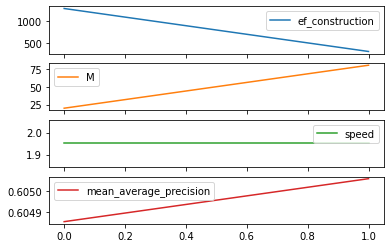

In [ ]:
df.plot.line(subplots=True)